# Traffic assignment

##### Laurent Pétré & Ilan Renous

We are going to integrate the density of car traffic under precise conditions. To do so, we are going to use a derivate of Euler's method. Let's get started!

In [27]:
# We import the libraries we will need
import numpy as npy
import matplotlib.pyplot as plt
%matplotlib inline
from JSAnimation.IPython_display import display_animation
import matplotlib.animation as anim

## Traffic density evolution equations

Let's take the example of a one way highway.
Let $V$ be the speed of traffic, in kilometers per hour.  We can also define a traffic density, the number of cars per unit length of highway, $\rho$, in cars per kilometer. Finally, we define the traffic flux, or the flow rate of cars, $F$ in cars per hour.

We need to make some assumptions about this system in order to find the evolution of these variables.

First, if $\rho$ approaches 0, i.e. there are very few cars on the road, then cars will drive as fast as they can at some $V_{max}$.  
Also, if cars are bumper to bumper along the road, $\rho$ will approach a maximum value $\rho_{max}$.

One possible equation for V is $$V = V_{max} \left(1 - \frac{\rho}{\rho_{max}} \right)$$

If we describe the traffic flux, $F$ as $$F = V\rho$$

then$$F = F(\rho) = V(\rho)\rho = V_{max} \rho \left(1 - \frac{\rho}{\rho_{max}} \right)$$

Unsteady traffic flow can be modelled as the non-linear convection of car density, so we apply the non-linear convection equation with $V$, the wave speed, equal to $ \partial F/\partial \rho$:$$  \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0$$

Applying the chain rule of calculus, this becomes $$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0$$

where $F$ is the flux.


### Implementation

We are going to define these function with python.


In [28]:
def speed(rho, rhomax = 250.0, Vmax = 22.22):
    """
    Returns the speed of the cars for a given density.
    
    Parameters
    ----------
    rho: float
        density of cars
        
    rhomax: float
        maximum density of cars
    
    Vmax: float
        maximum speed of cars
        
    Returns
    -------
    speed : float
        computed value of speed
    """

    return Vmax*(1-rho/rhomax)

def flux(rho, rhomax = 250.0, Vmax = 22.22):
    """
    Returns the traffic flux for a given density.
    
    Parameters
    ----------
    rho: float
        density of cars
        
    rhomax: float
        maximum density of cars
    
    Vmax: float
        maximum speed of cars
        
    Returns
    -------
    flux: float
        computed value of flux
    """

    return speed(rho, rhomax, Vmax)*rho

## Discretisation of the problem

Now, we need to discretise time and space in order to find a numerical approximation to the following problem:

$$\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0$$

To do so we are going to use mulivariate Euler's method to find a discrete approximation. Euler's method is equivalent to using a forward-difference scheme for the time derivative and the backward-difference scheme for the space derivative. With this convention, our discrete equation is:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + \frac{f_i^n - f_{i-1}^n}{\Delta x} = 0 $$

where $n$ and $n+1$ are two consecutive steps in time, while $i-1$ and $i$ are two neighboring points of the discretized $x$ coordinate. With given initial conditions, the only unknown in this discretization is $u_i^{n+1}$.  We solve for this unknown to get an equation that lets us step in time, as follows:

$$u_i^{n+1} = u_i^n - \frac{\Delta t}{\Delta x}(f_i^n-f_{i-1}^n)$$

In [29]:
def solve(u_t0, u_x0, f, dt, dx, nt, callback):
    """
    Compute the solution of the partial differential equation : 
    du/dt + df(u)/dx = 0.
    
    Parameters
    ----------
    u_t0: array of floats
        initial condition
        
    u_x0(n): function of an integer returning a float
        function giving the boundary condition
    
    f(u): function of an array of floats returning an array of floats
        see de definition of the PDE
        
    dt: float
        time step
        
    dx: float
        space step
        
    nt: integer
        number of iterations
        
    callback(n, u): function of the iteration and an array of floats
        the array of floats is the value of the solution for that iteration
    """
    
    u = u_t0.copy() # We do not want to modify the given variables
    Fn = f(u_t0)

    for n in range(1, nt):
        un = u.copy()
        u[1:] = un[1:]-dt/dx*(Fn[1:]-Fn[0:-1]) 
        u[0] = u_x0(n)
        Fn = f(u) # We need to compute the f(u) value after each iteration

        callback(n, u)

## Solve !

We are going to find the evoltion of the density in time. We use the following initial conditions:
* $L=11000 m$
* $\rho{max}=250 cars/km$
* $nx=51$
* $\Delta t=3.6s$

where $nx$ is the number of space steps and $\Delta t$ the time step.

In [30]:
L = 11000.0

nx = 51
dx = L/(nx-1)

x = npy.linspace(0, L, nx) # We discritise space in nx parts

dt = 3.6

### Useful functions

In order to draw some animations, we need to save the datas then plot them. This is why we define two functions here. The first one is used as a callback in the solve function and allows us to save the datas. The second one is there to plot them for each iteration.

In [31]:
def save_data(n, u, u_f):
    """
    Save datas in array.
    
    Parameters
    ----------
    n: integer
        index of the data to save
        must not overpass N
        
    u: whatever
        data to save
    
    u_f: array[N] of whatever
        array to save the datas
    """
        
    u_f[n, :] = u

def set_plot(i, line, x, u):
    """
    Plot line for a given iteration.
    
    Parameters
    ----------
    i: integer
        iteration index
        must not overpass M
        
    line: matplolib line
        line to draw
        
    x: array[N] of floats
        data for the x axe
    
    u: array[MxN] of floats
        data for the y axe with the following structure : u[i, :]
    """
    
    line.set_data(x, u[i, :])

### First set of initial conditions

Let's take the following values for the first simulation:
* $V_{max}=22.22m/s$
* $\rho(0,t)=10$
* $\rho(x/[10,20],0) =10 \\\rho([10,20],0) = 50$

In [32]:
# Initial coniditions
t_to_sim = 360
nt = int(t_to_sim/dt)

rho0 = npy.ones(nx)*10.0
rho0[10:20] = 50.0

# Creation of the array to save the datas for the plot
rho = npy.empty((nt, 51))
rho[0, :] = rho0

solve(rho0, lambda n: 10.0, flux, dt, dx, nt, \
      lambda n, u: save_data(n, u, rho))

# The average speed at t=3min is given at the 49th line of the array
print(speed(npy.mean(rho[49, :]))) 
# For the minimum speed, we need the maximum density
print(speed(npy.amax(rho[99, :])))

20.634102285
18.7747620644


* The average speed at $t=3min$ is $V=20.63 m/s$
* The minimum speed at time $t=6min$ is $V=18.77m/s$


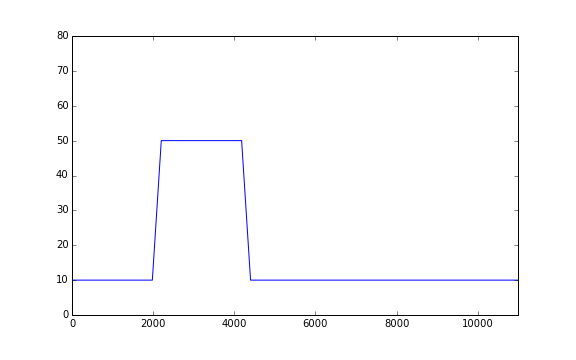
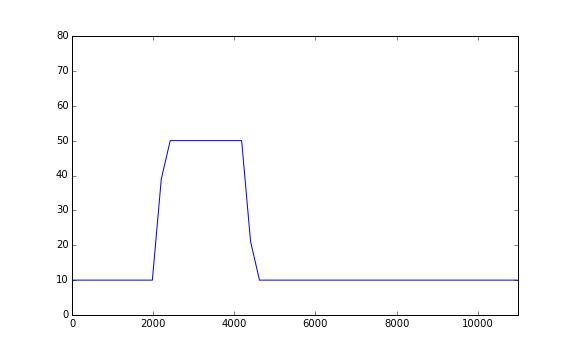
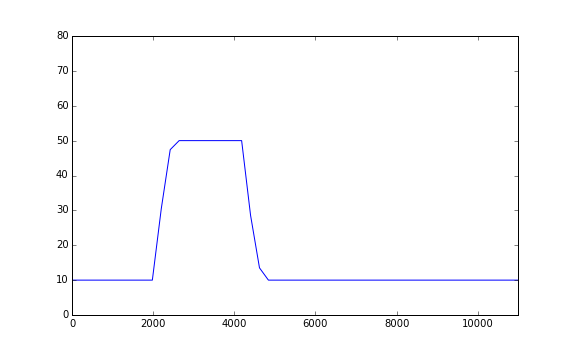
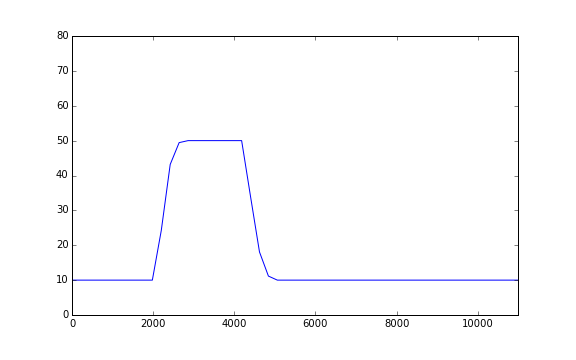
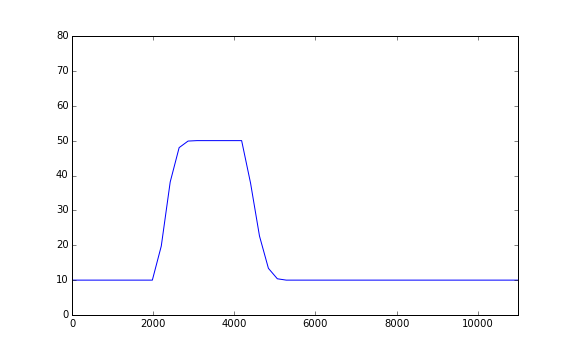
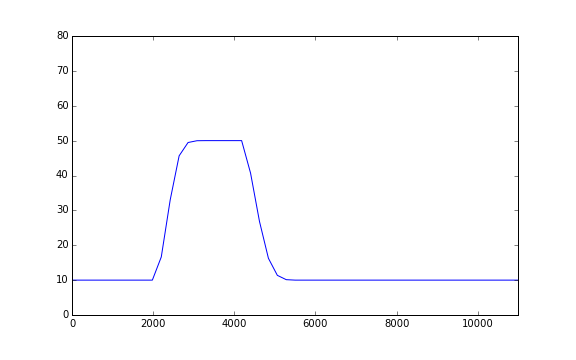
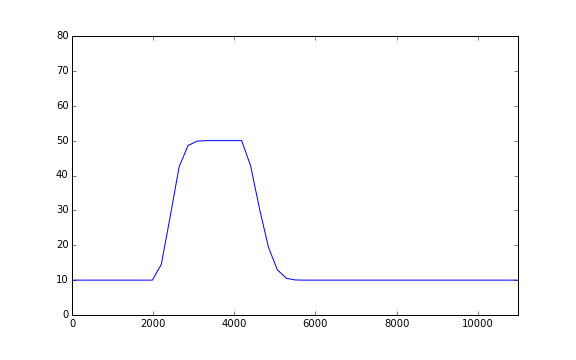
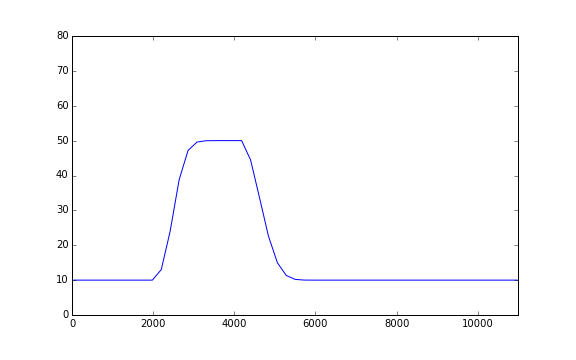
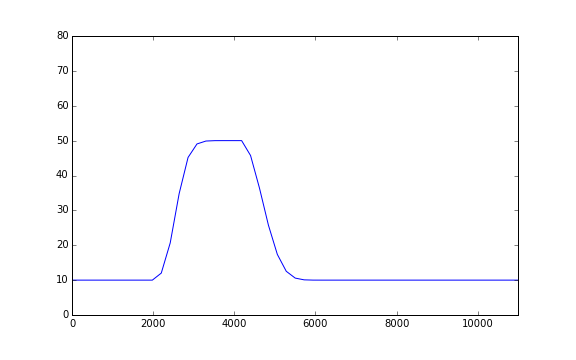
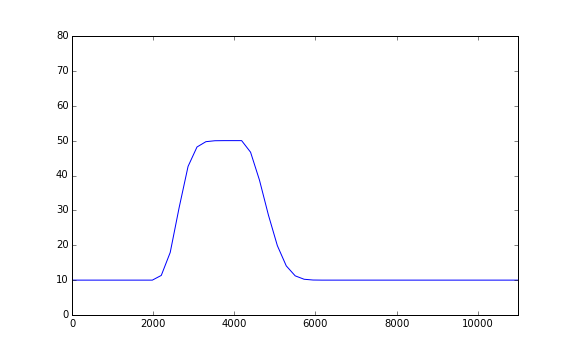
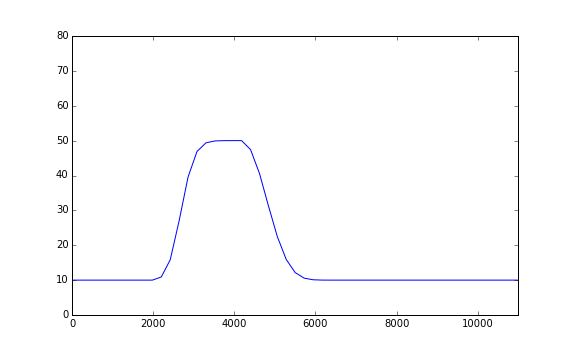
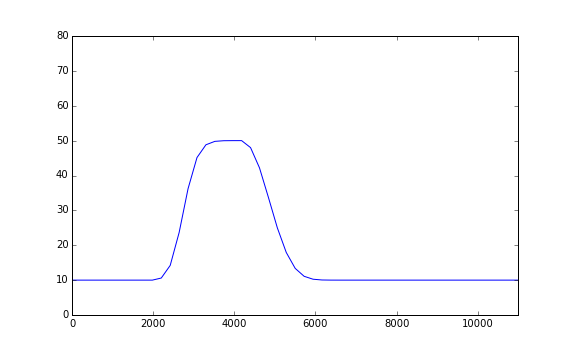
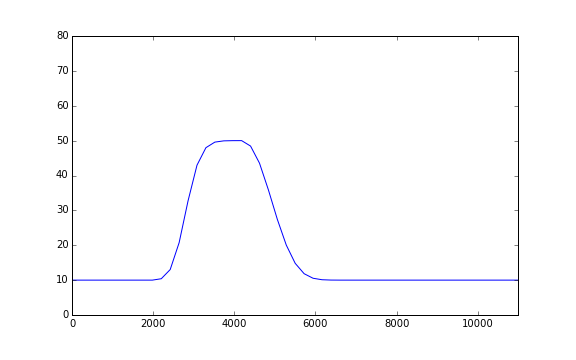
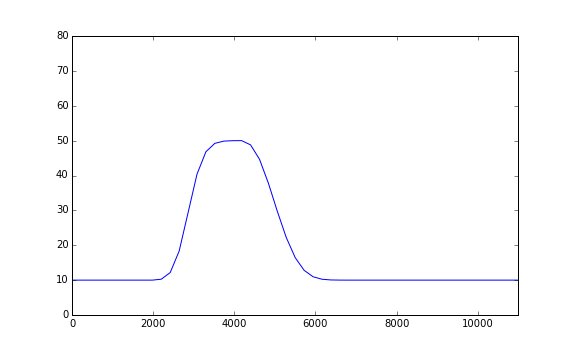
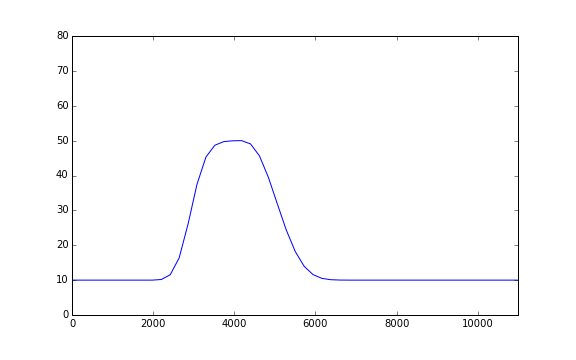
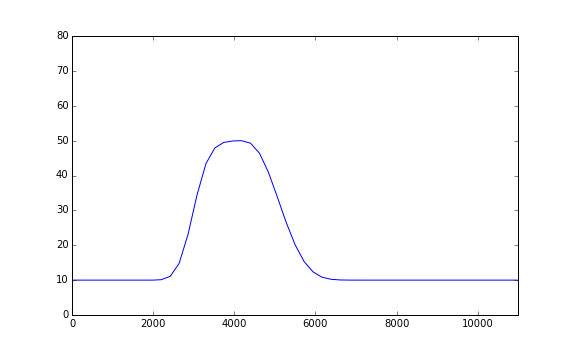
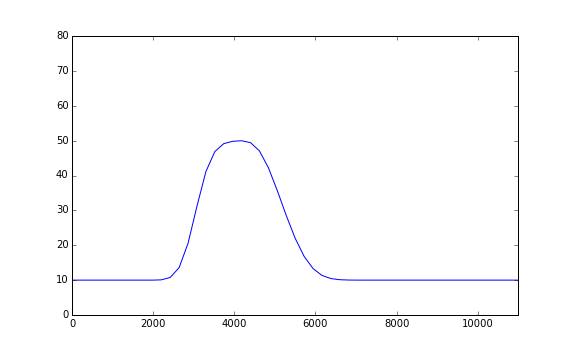
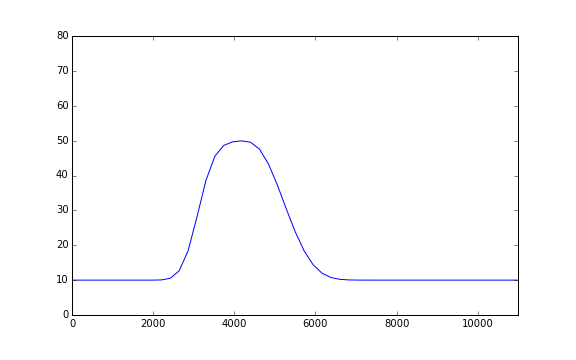
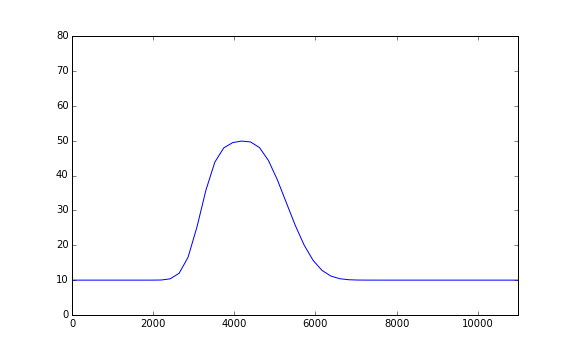
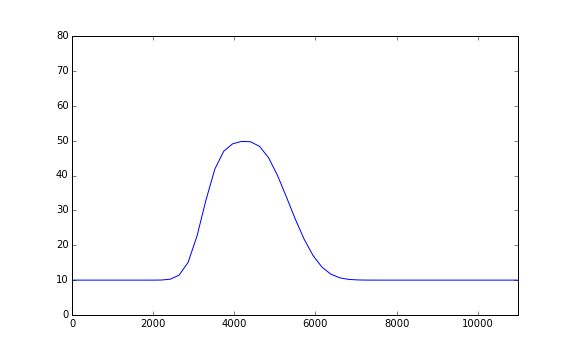
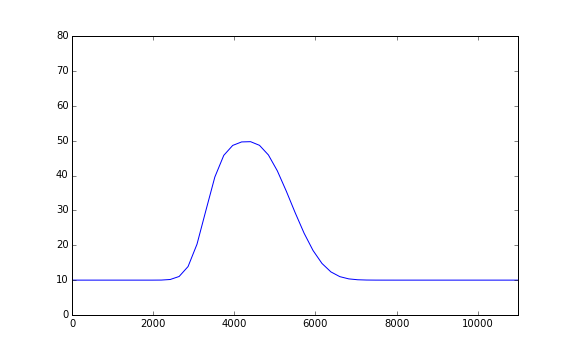
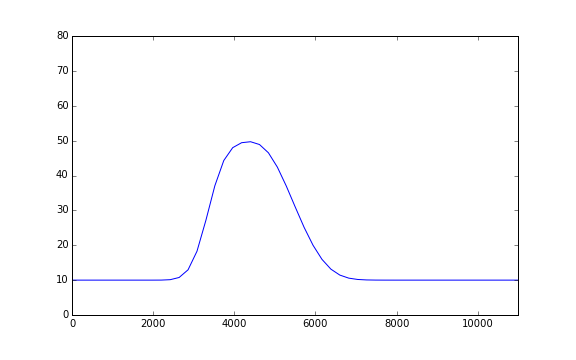
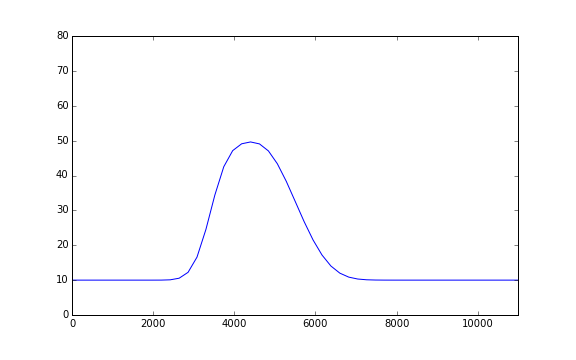
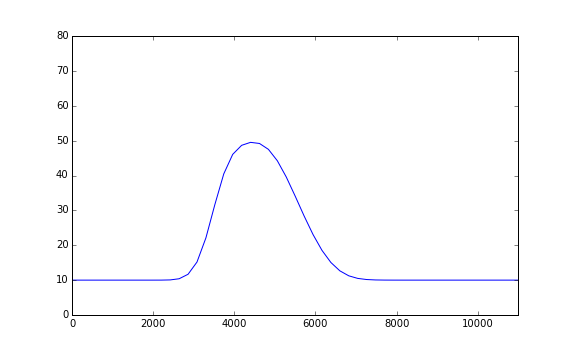
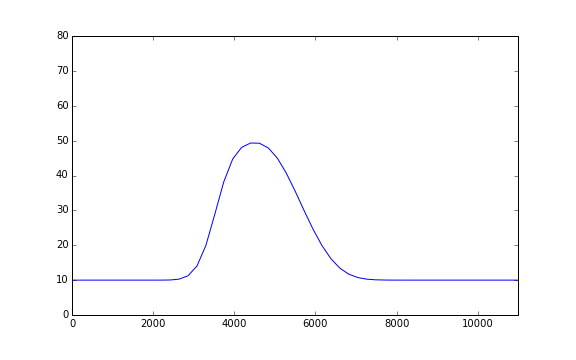
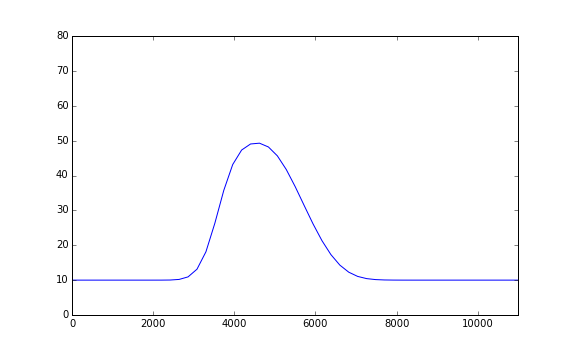
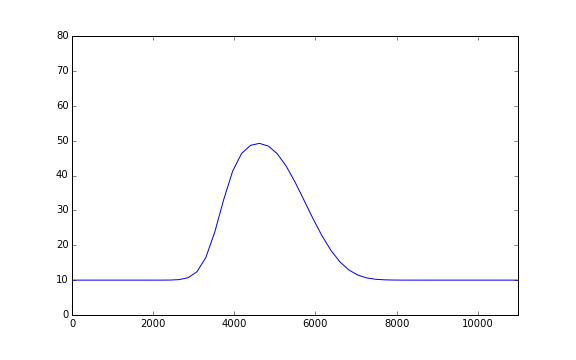
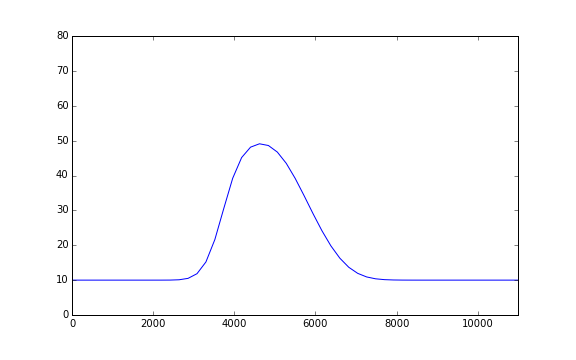
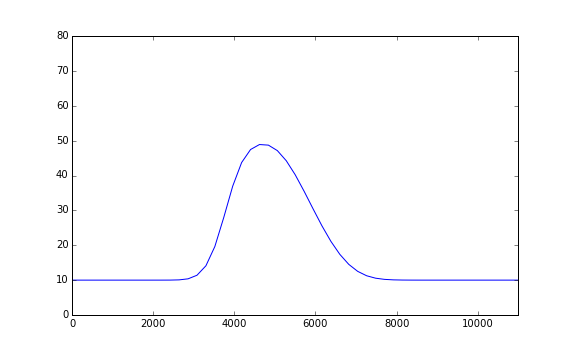
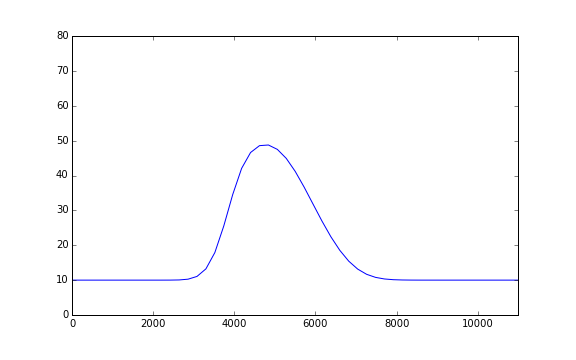
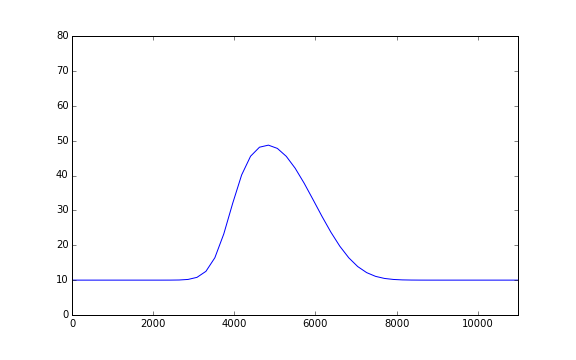
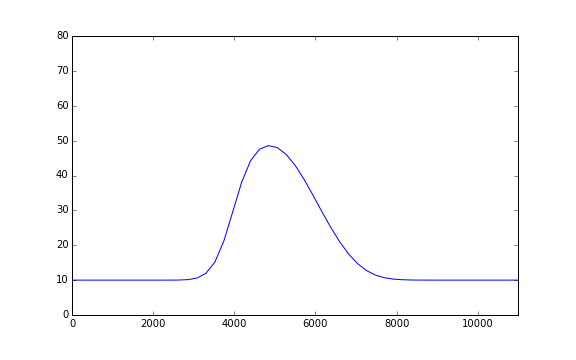
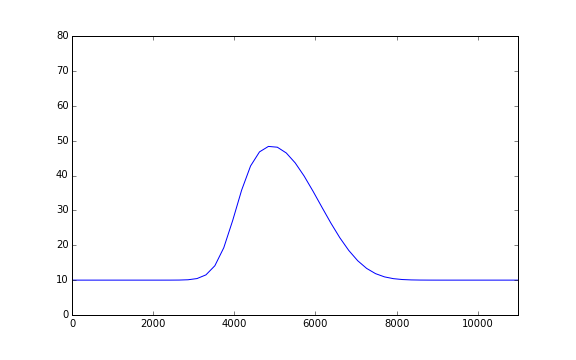
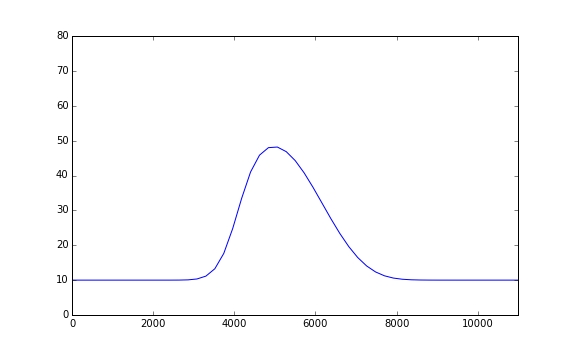
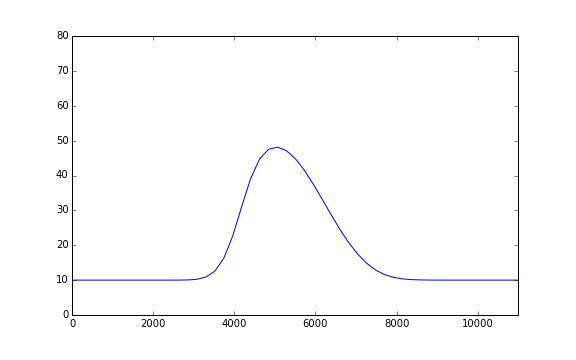
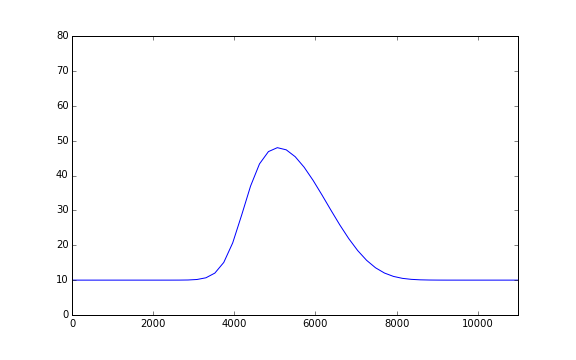
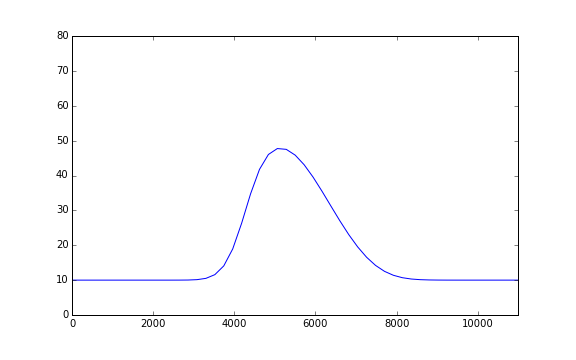
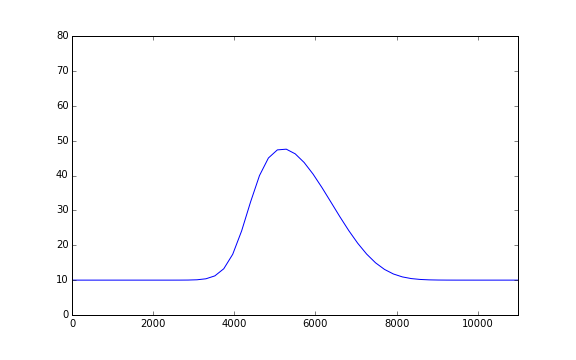
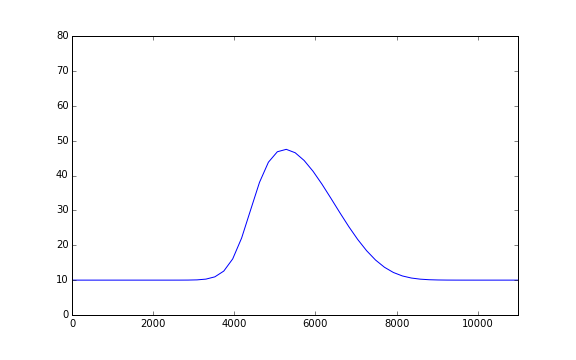
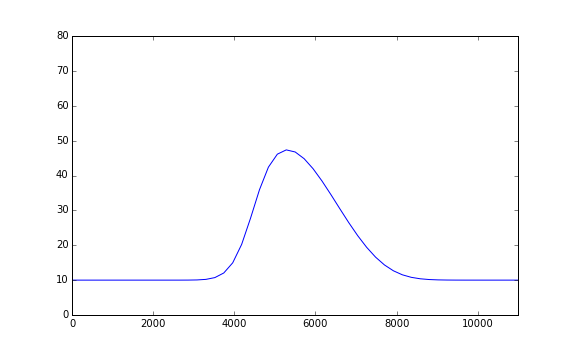
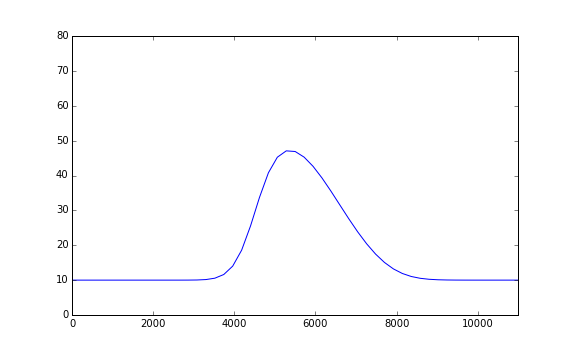
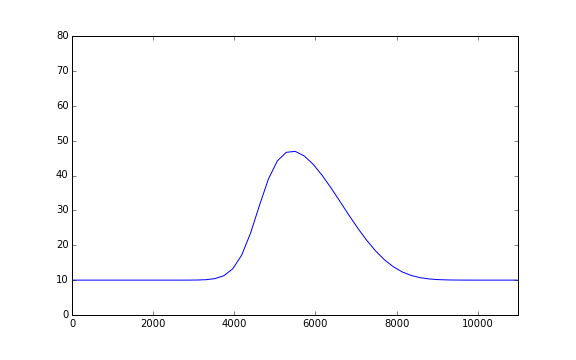
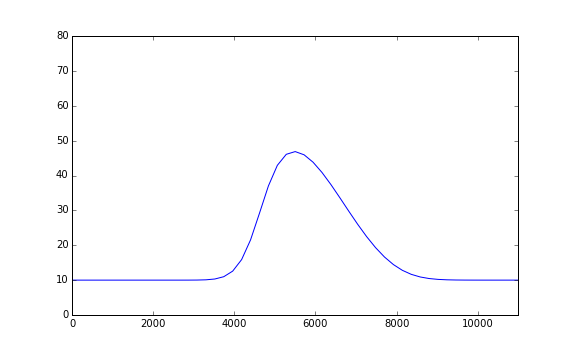
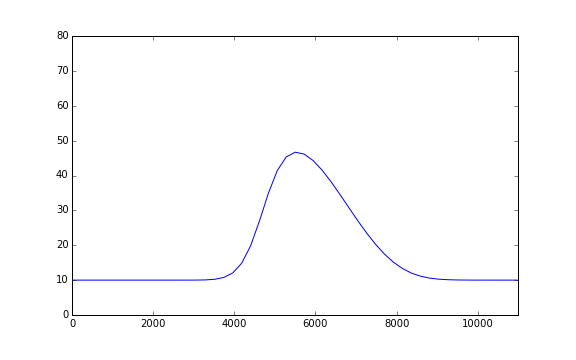
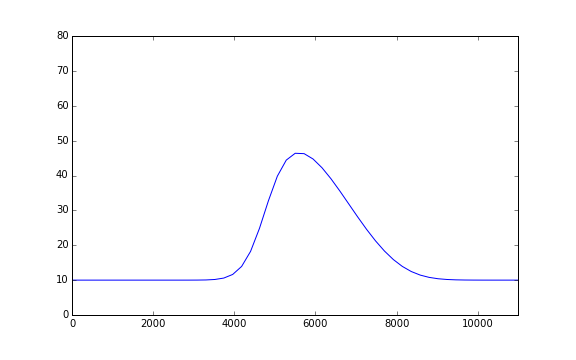
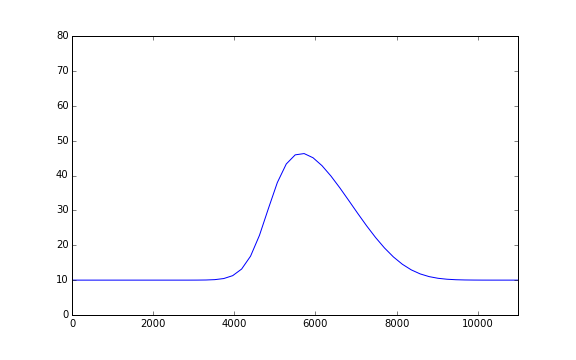
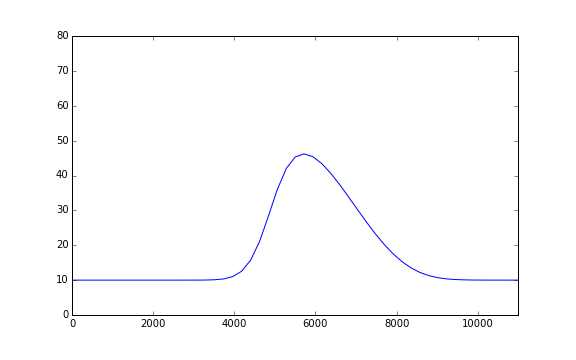
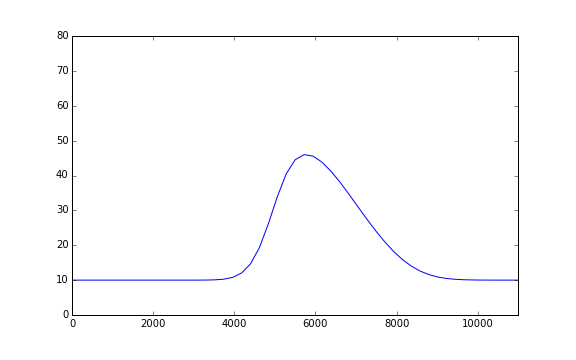
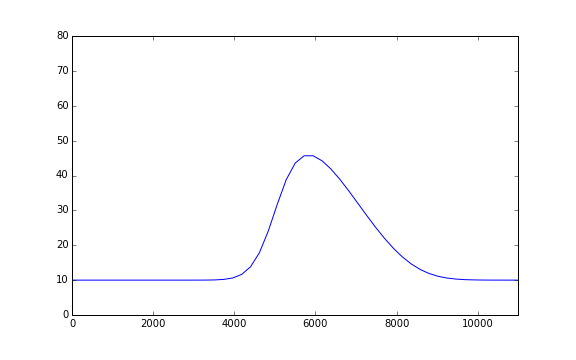
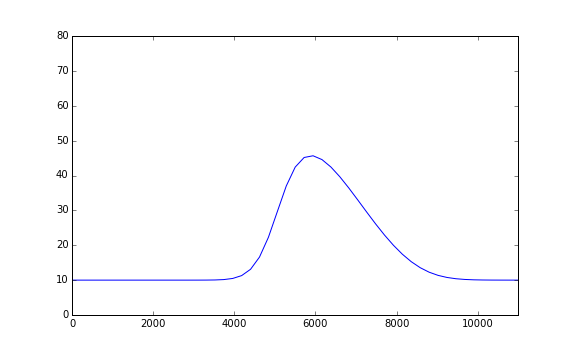
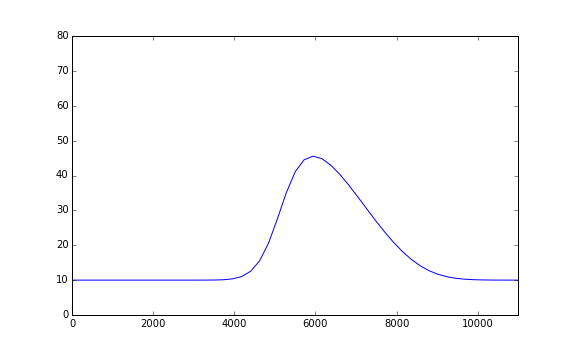
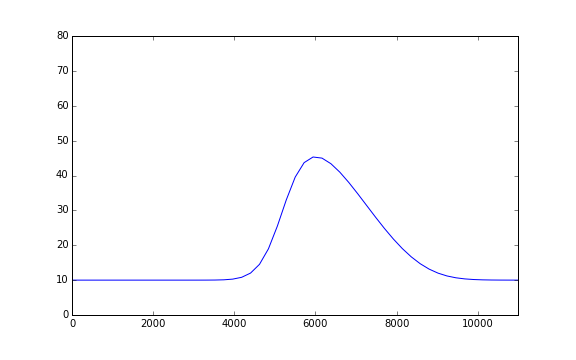
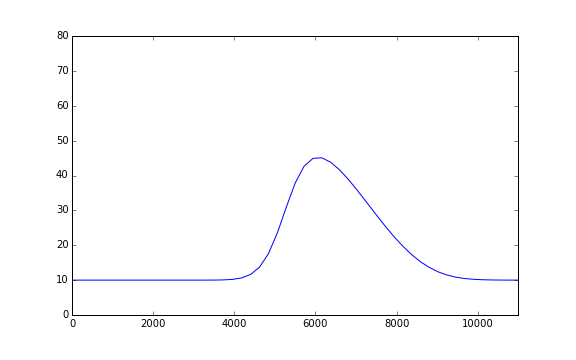
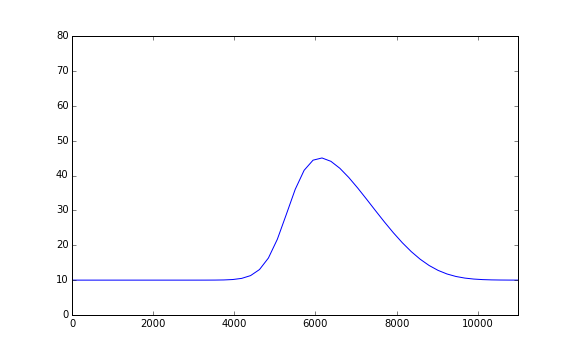
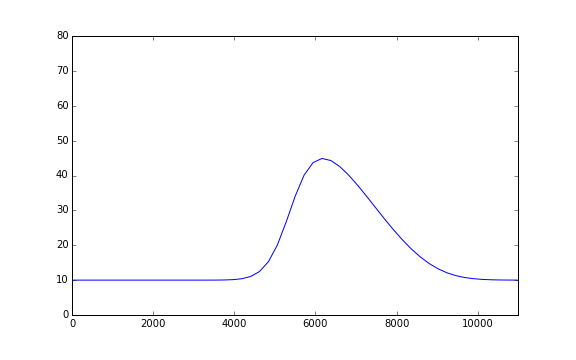
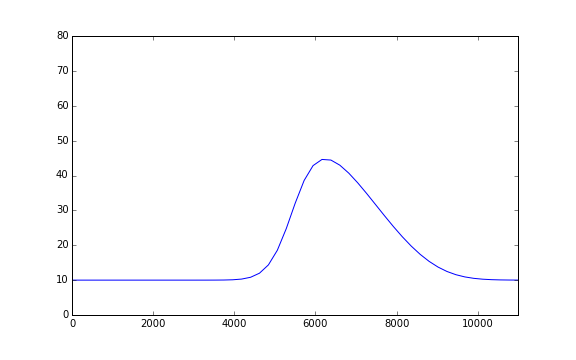
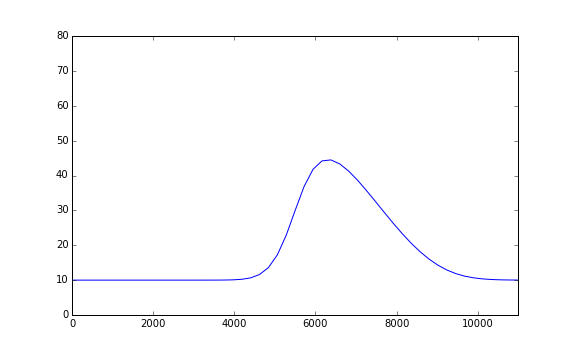
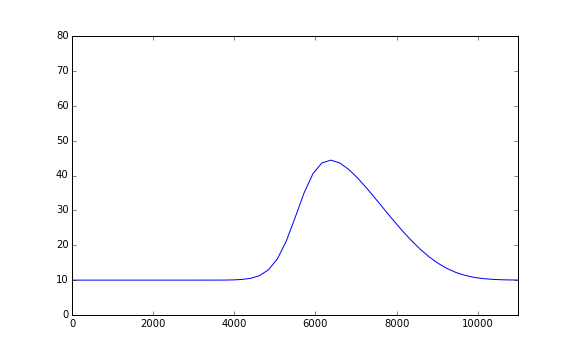
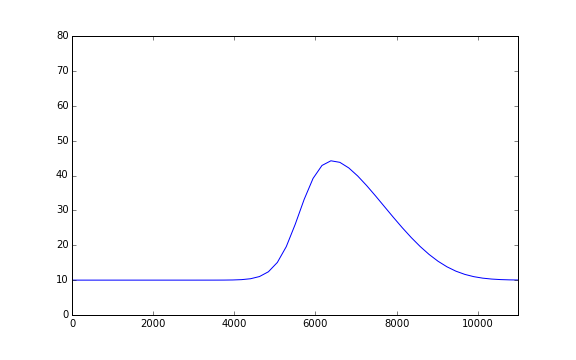
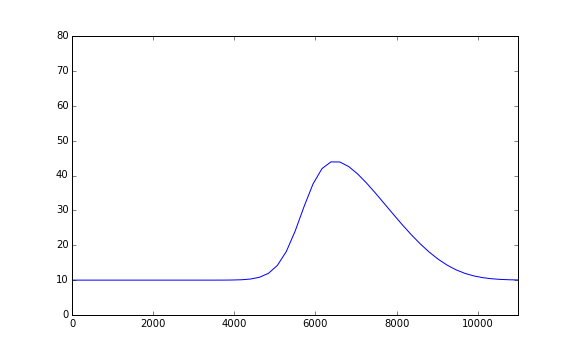
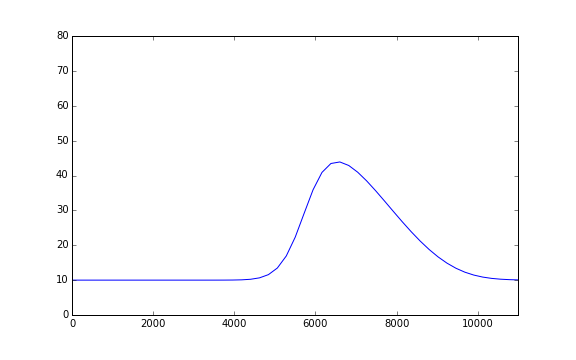
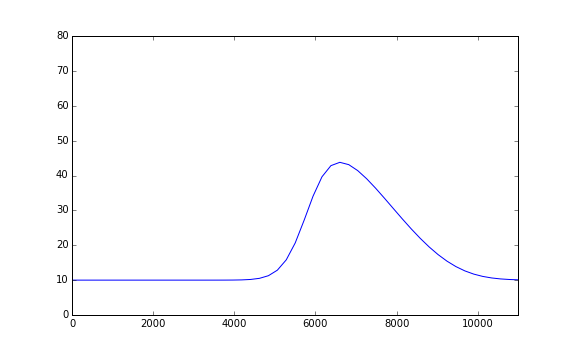
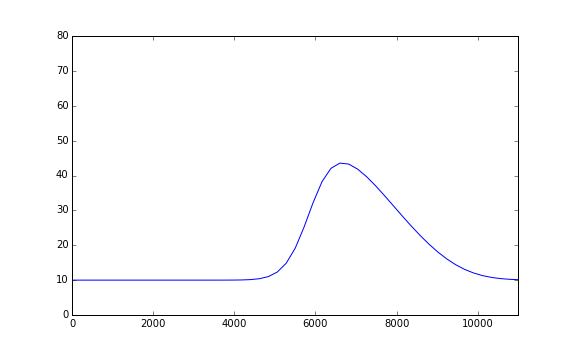
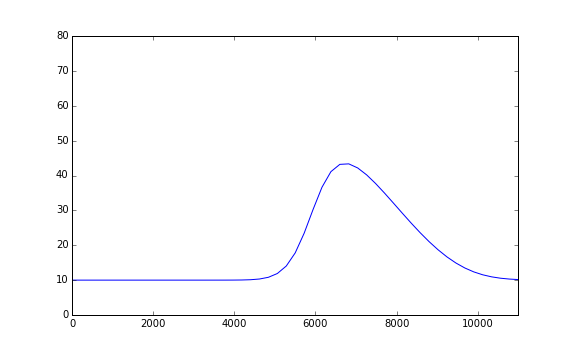
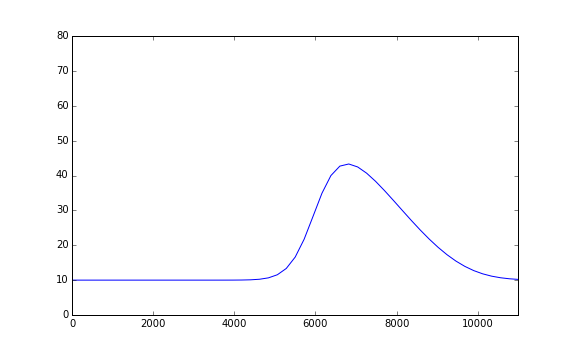
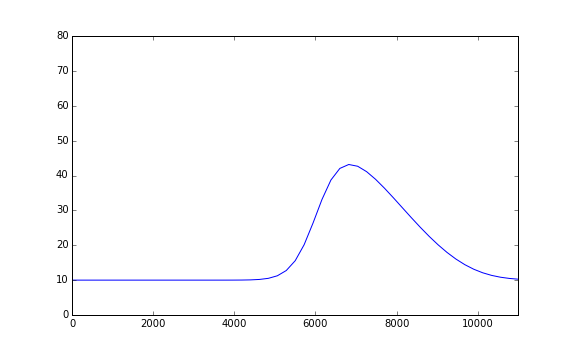
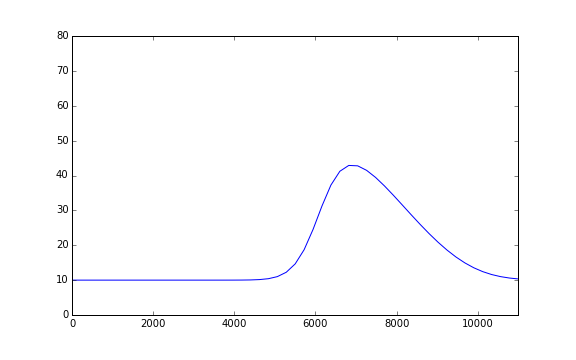
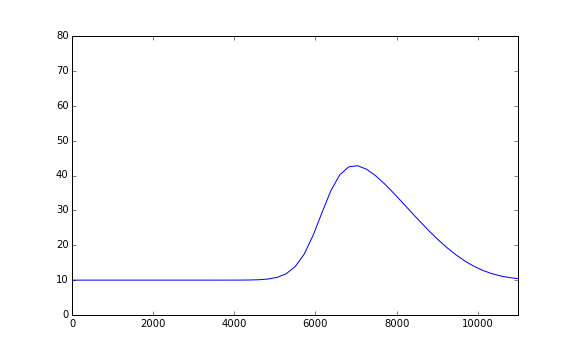
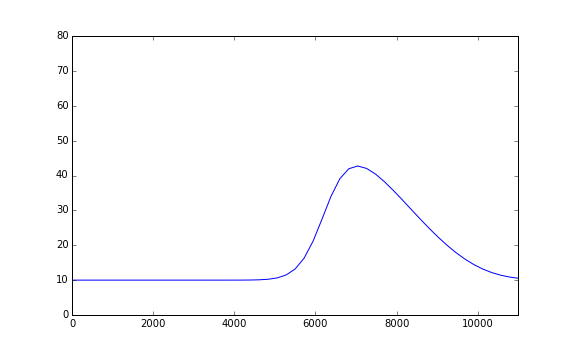
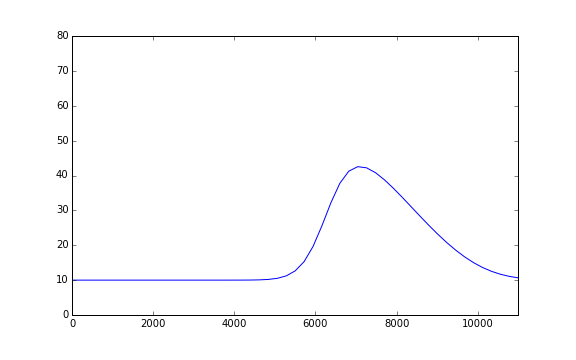
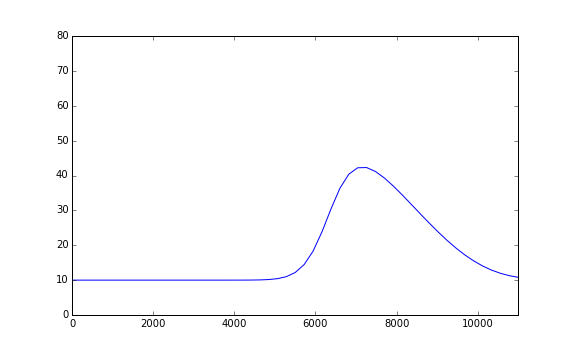
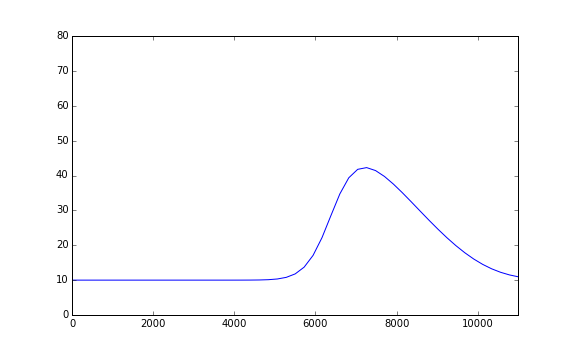
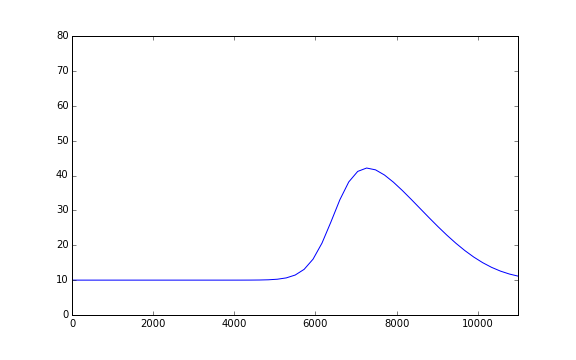
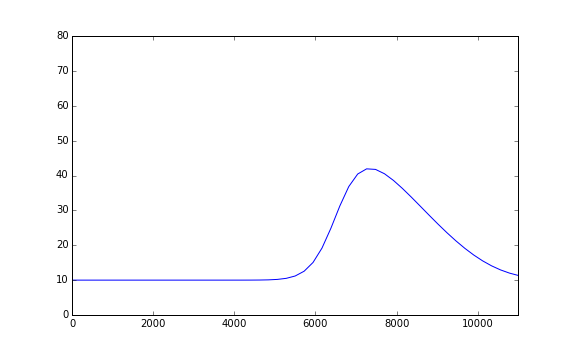
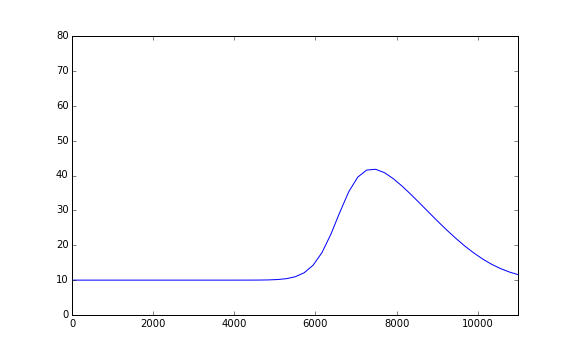
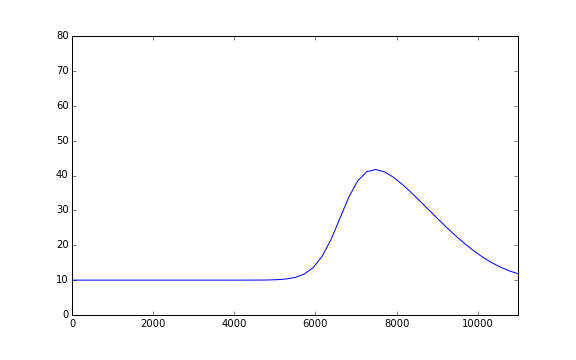
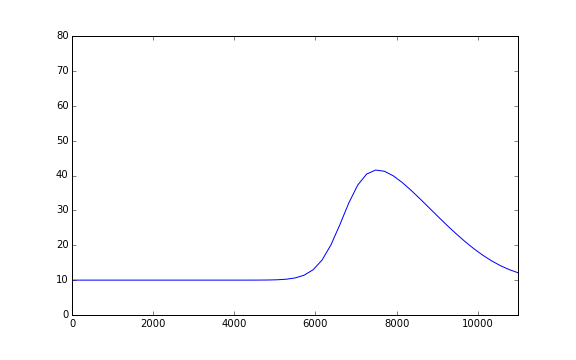
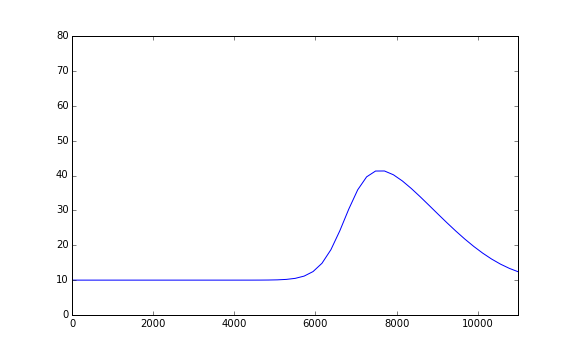
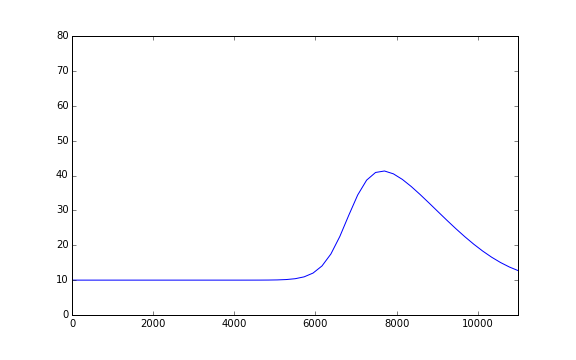
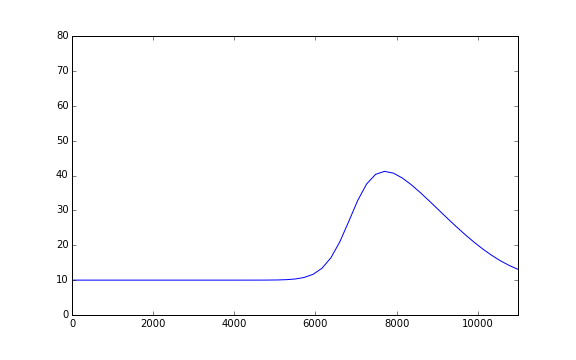
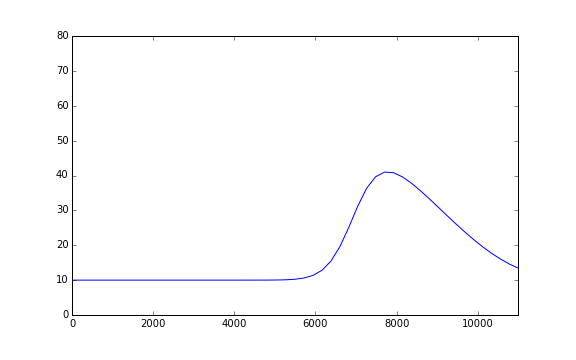
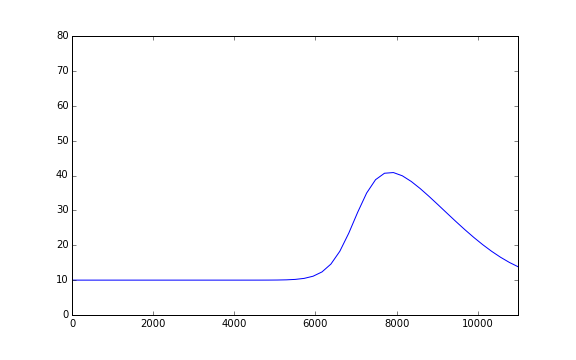
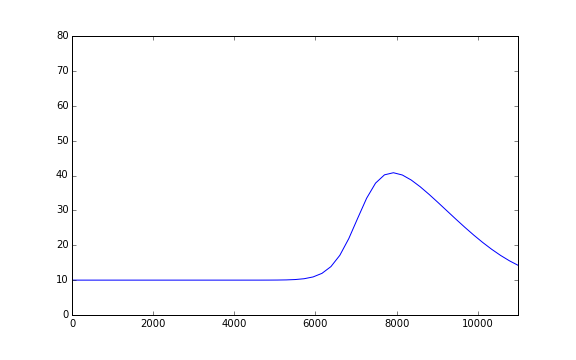
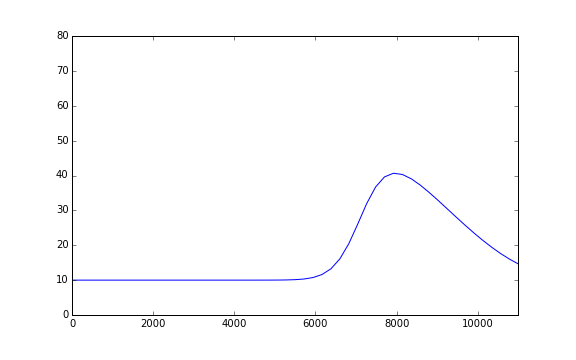
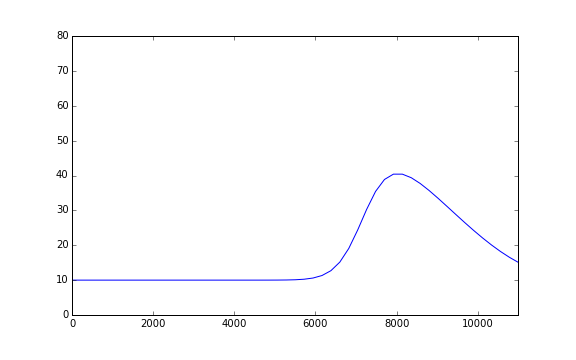
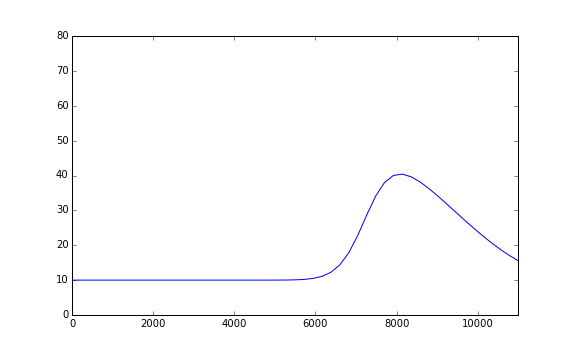
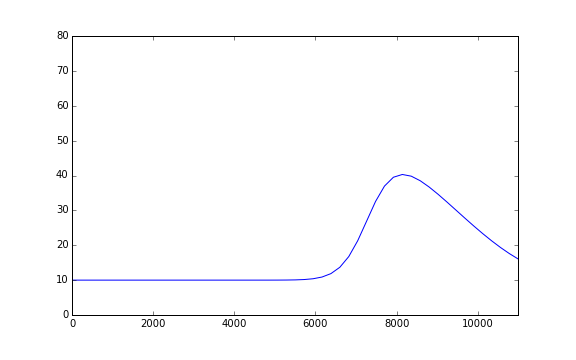
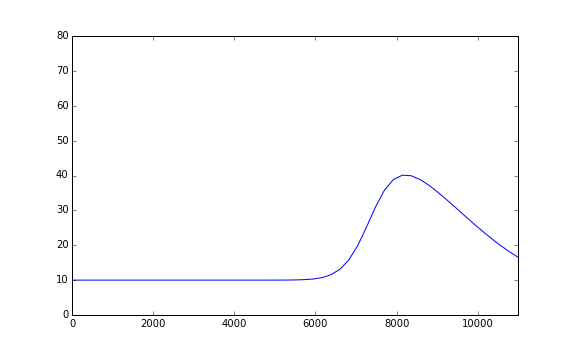
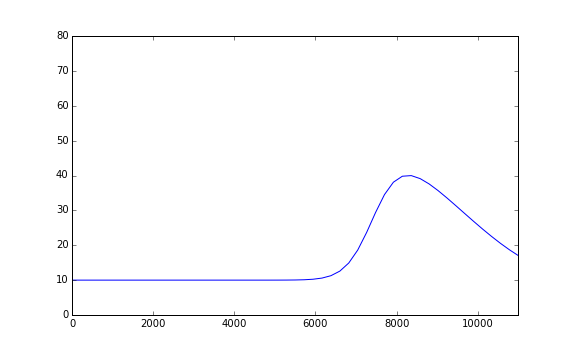
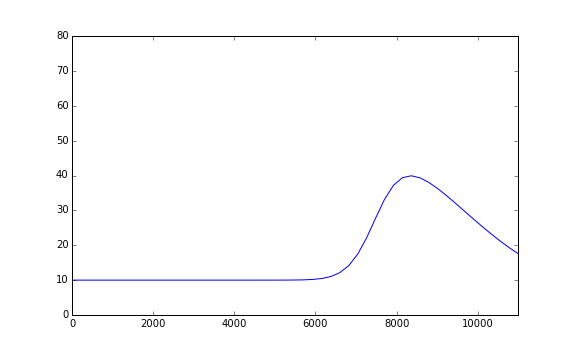
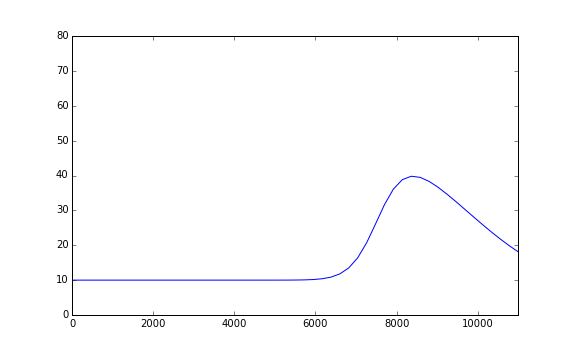
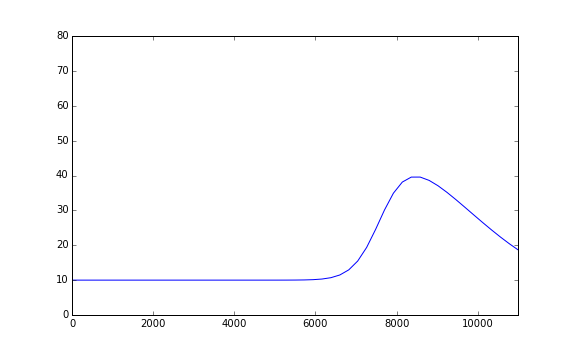
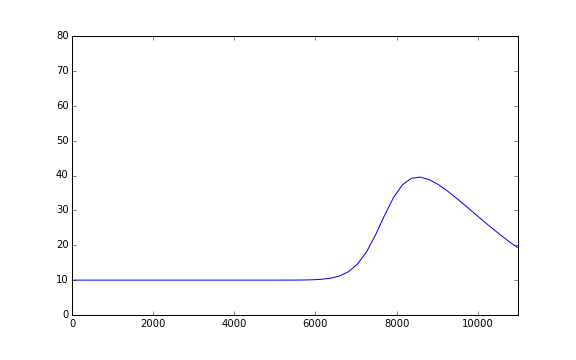
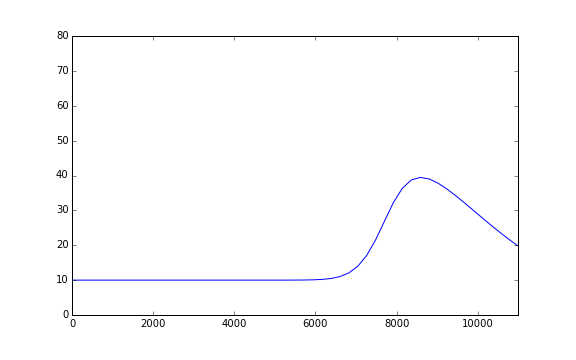
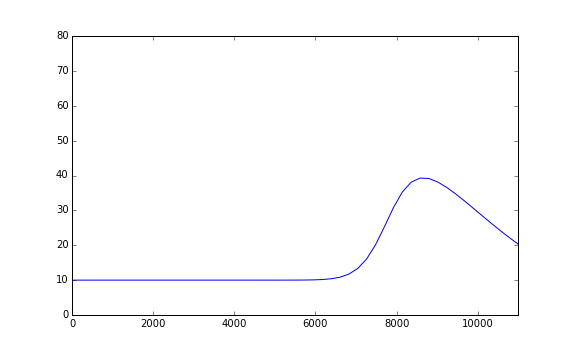
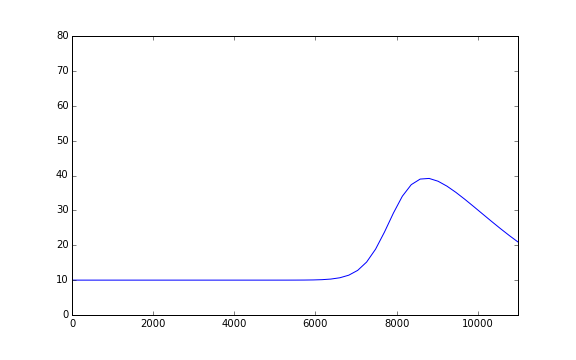
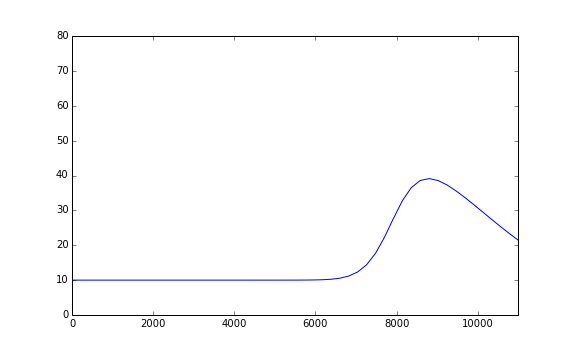
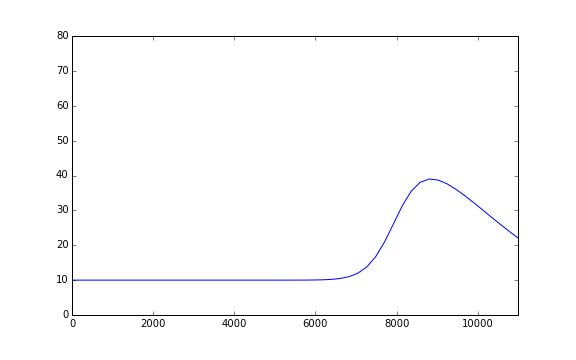
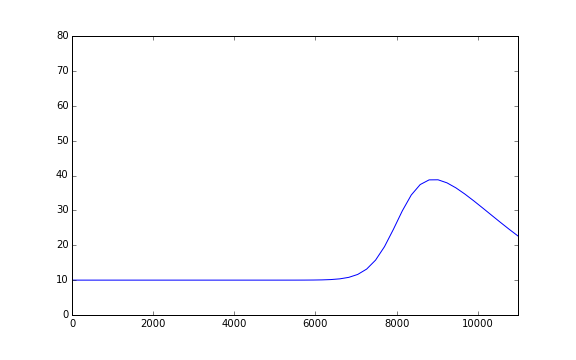
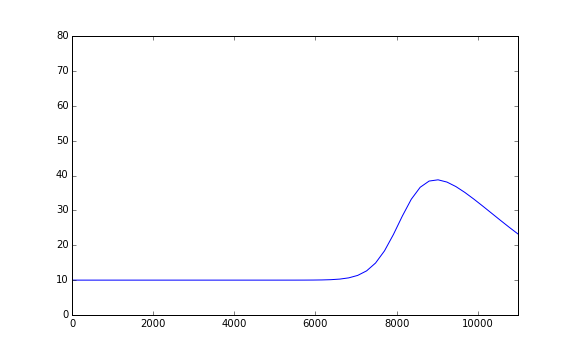

In [33]:
# Creation of the animation
fig = plt.figure(figsize=(8,5))
ax = plt.axes(xlim=(0,11000), ylim=(0,80))
line = ax.plot([], [])[0]

anim.FuncAnimation(fig, lambda i: set_plot(i, line, x, rho),
                        frames=nt, interval=80)

### Second set of inital conditions

Let's take the following values for the second simulation:
* $V_{max}=37.78m/s$
* $\rho(0,t)=20$
* $\rho(x/[10,20],0) =20 \\\rho([10,20],0) = 50$

In [34]:
# Initial coniditions
t_to_sim = 180
nt = int(t_to_sim/dt)

rho0 = npy.ones(nx)*20.0
rho0[10:20] = 50.0

# Creation of the array to save the datas for the plot
rho = npy.empty((nt, 51))
rho[0, :] = rho0

solve(rho0, lambda n: 20.0, lambda u: flux(u, Vmax = 37.78), \
      dt, dx, nt, lambda n, u: save_data(n, u, rho))

# The average speed at t=3min is given at the 49th line of the array
print(speed(npy.mean(rho[49, :]),Vmax=37.78))
# For the minimum speed, we need the maximum density
print(speed(npy.amax(rho[49, :]),Vmax=37.78))

33.87248308
30.948046861


* The average speed at $t=3min$ is $V=33.87 m/s$
* The minimum speed at time $t=3min$ is $V=30.94m/s$


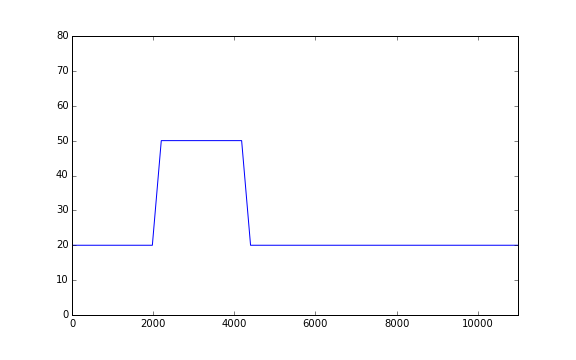
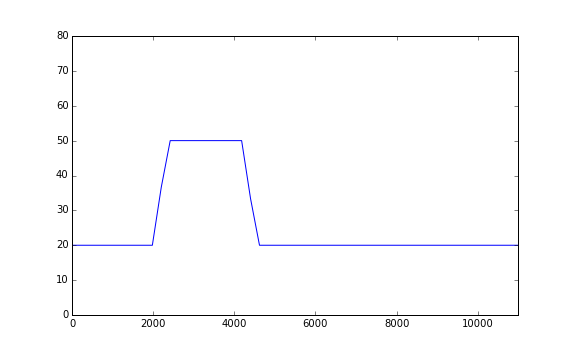
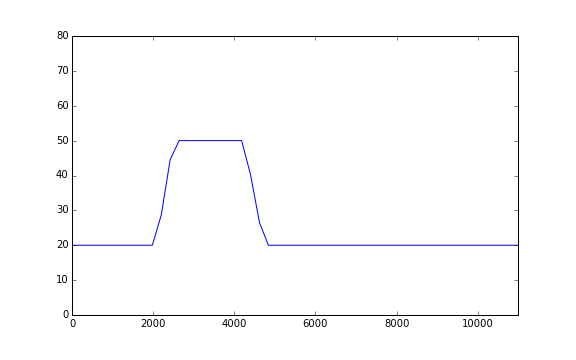
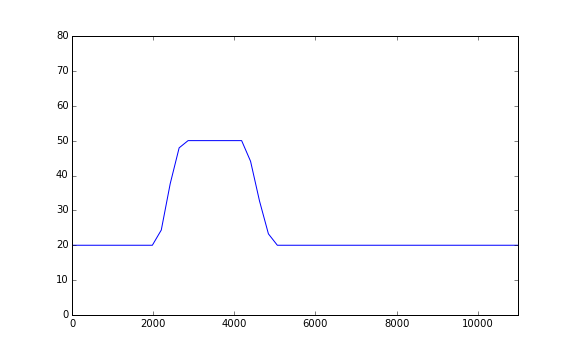
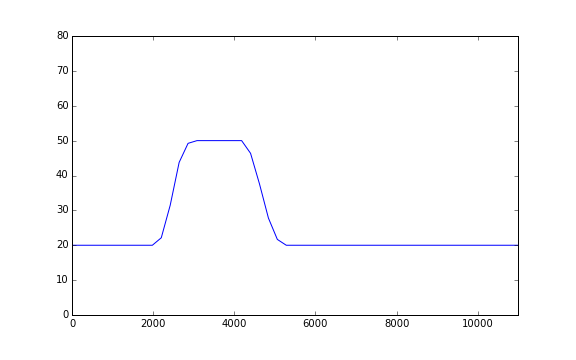
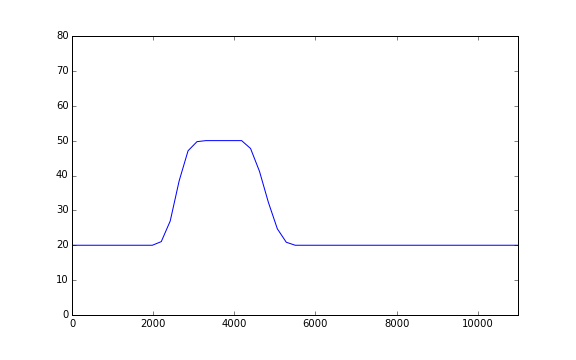
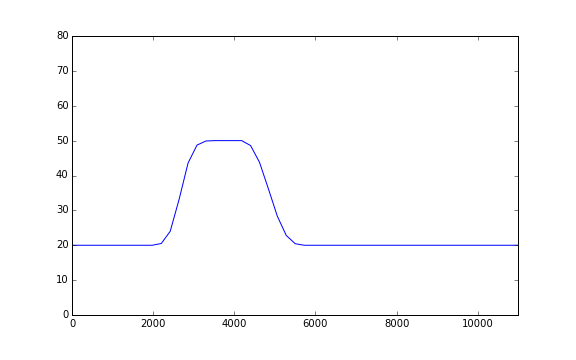
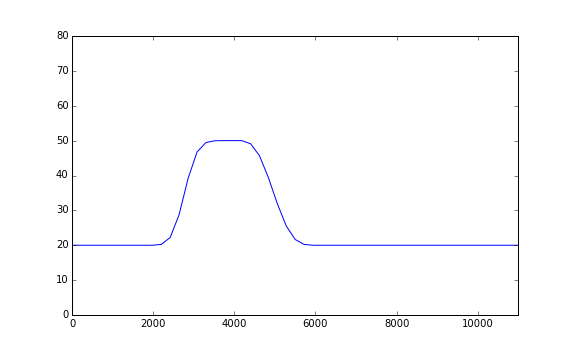
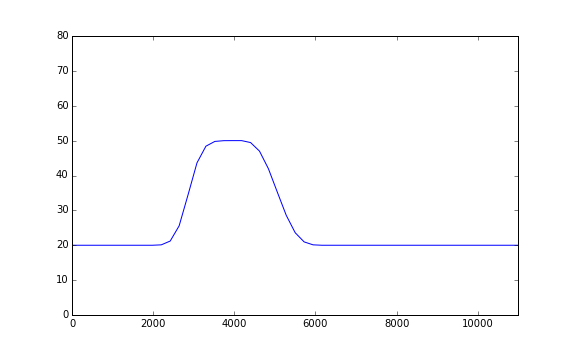
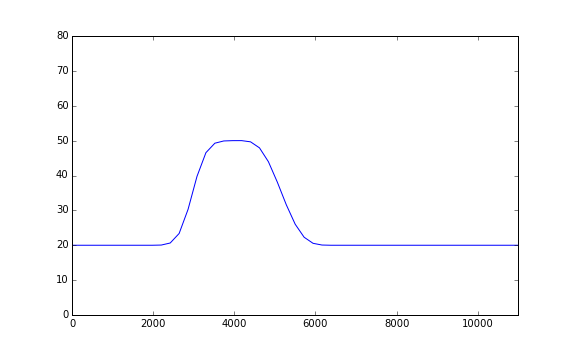
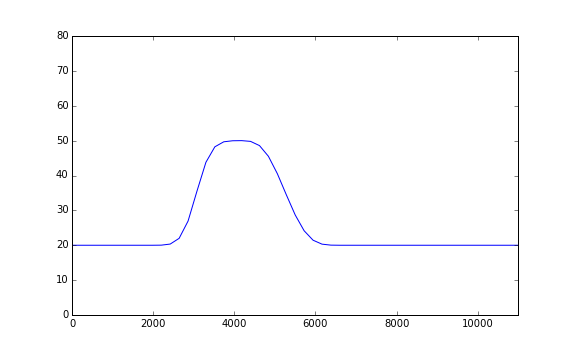
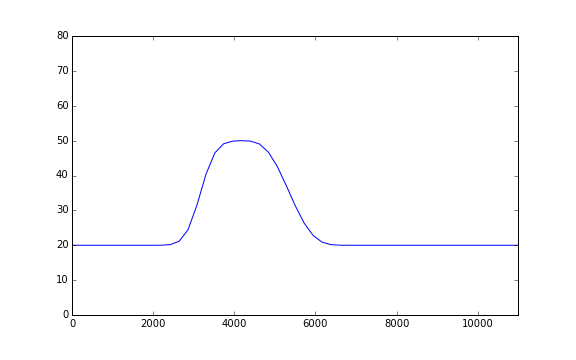
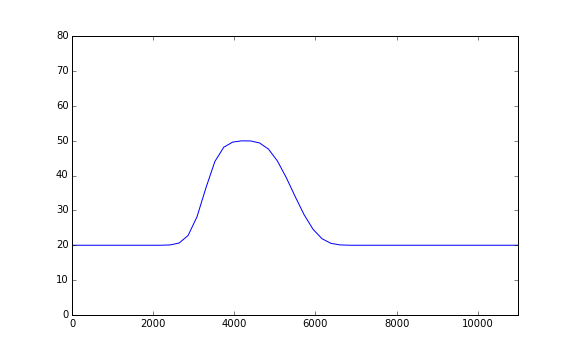
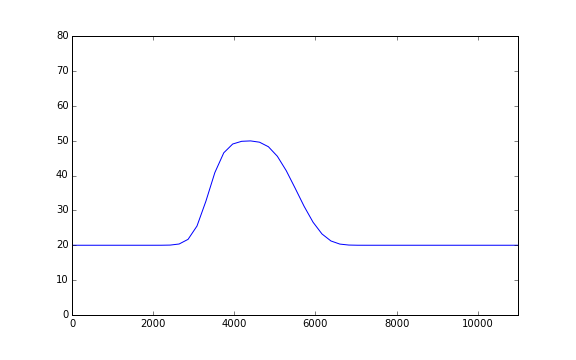
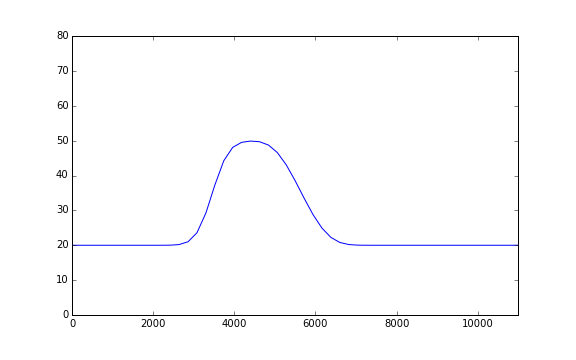
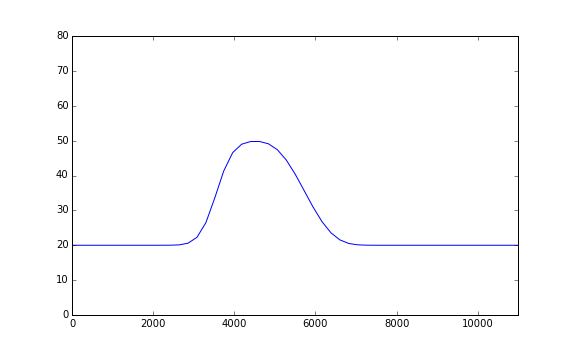
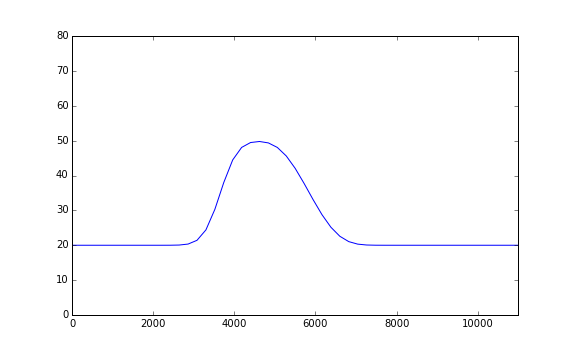
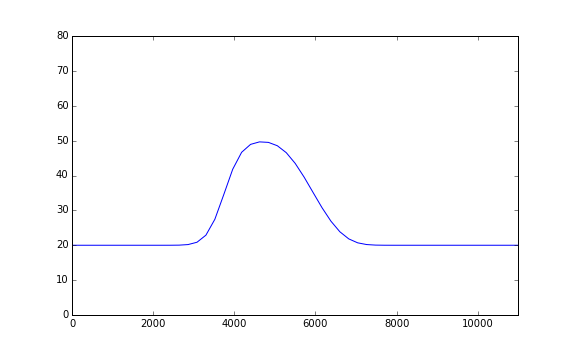
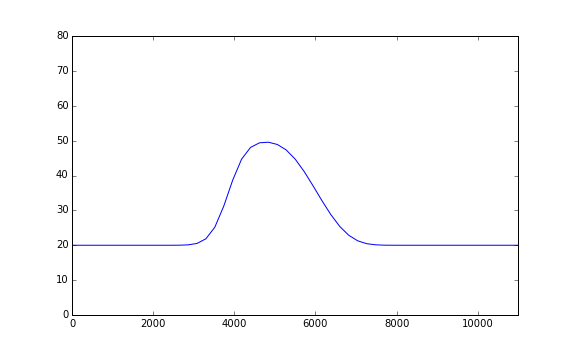
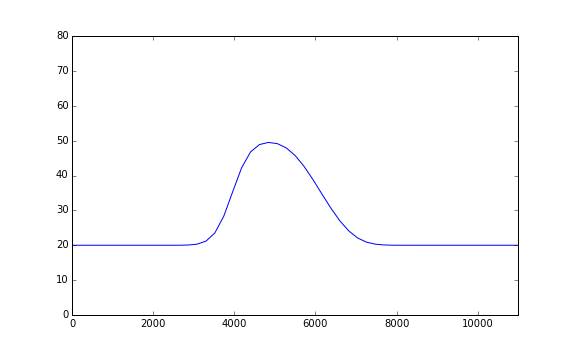
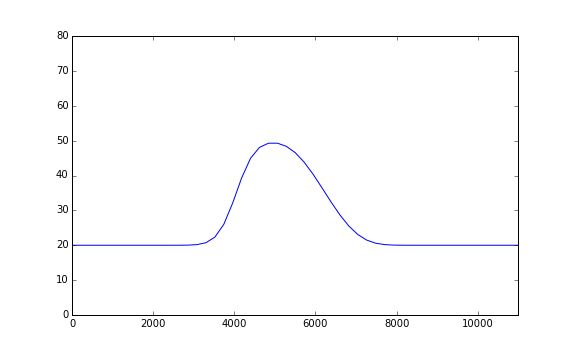
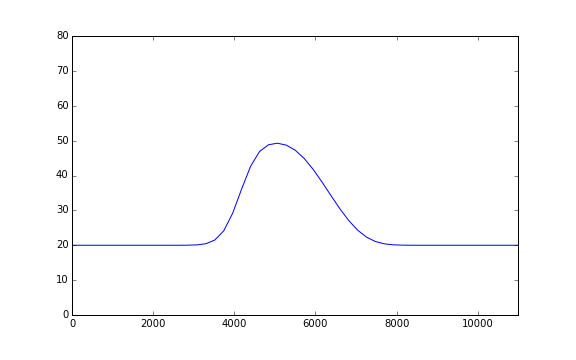
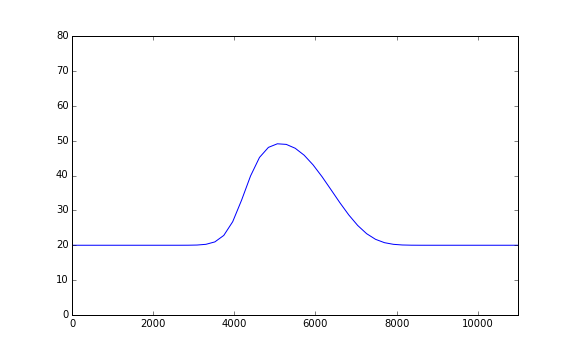
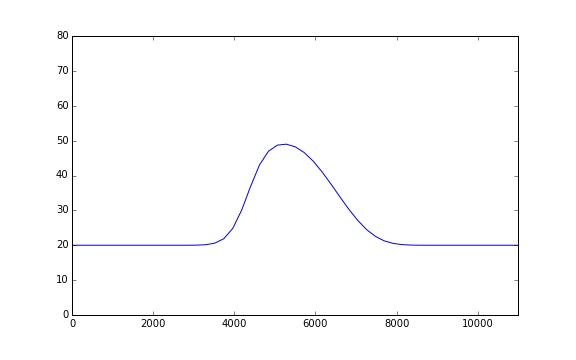
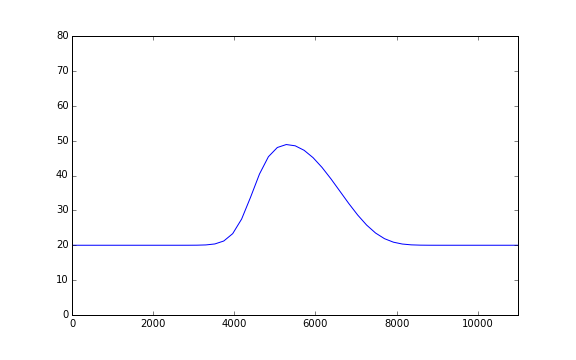
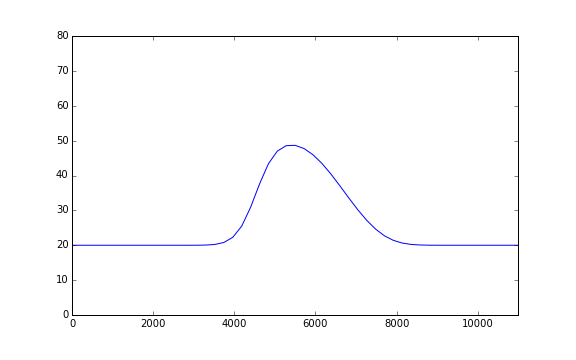
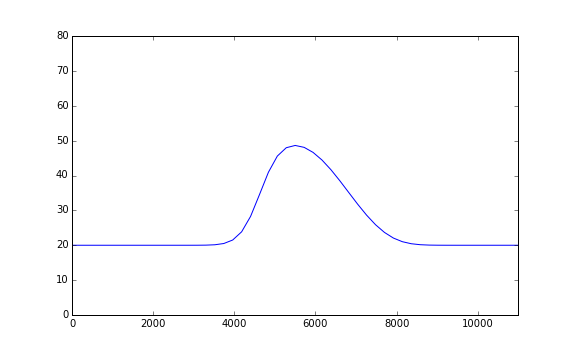
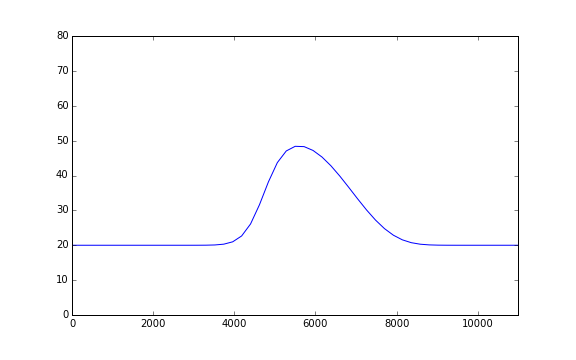
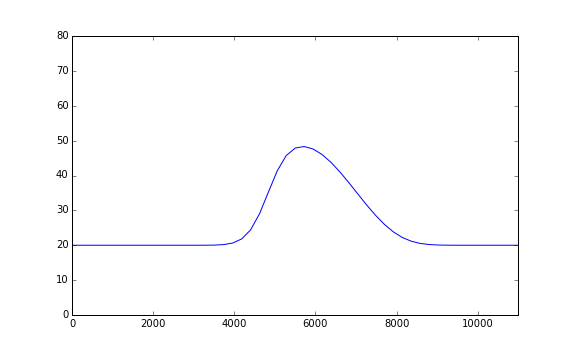
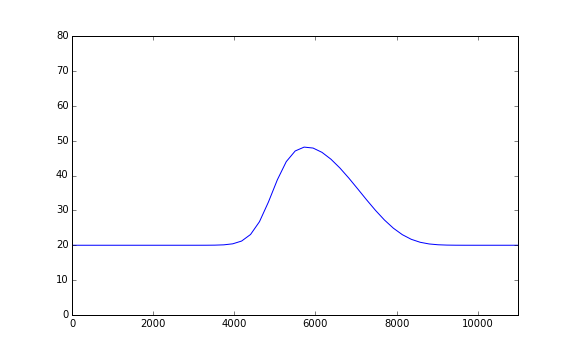
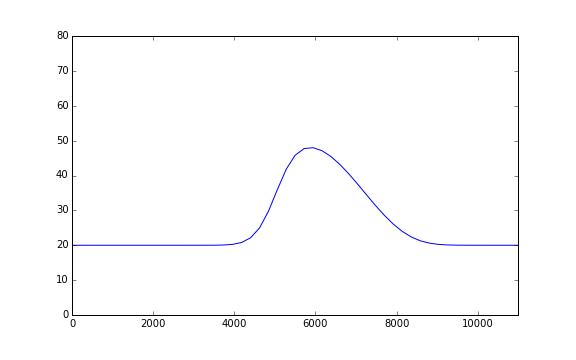
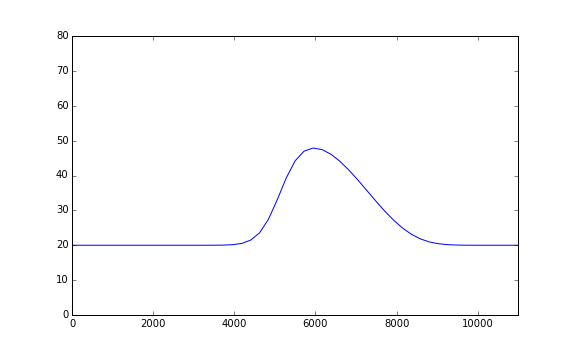
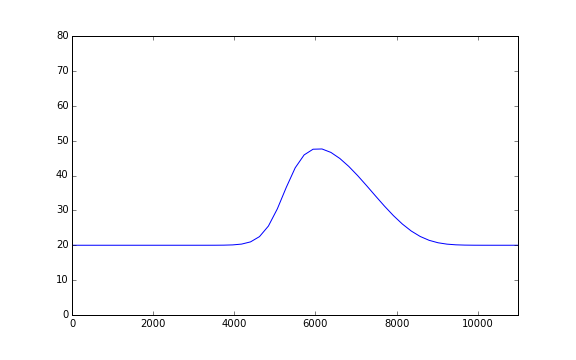
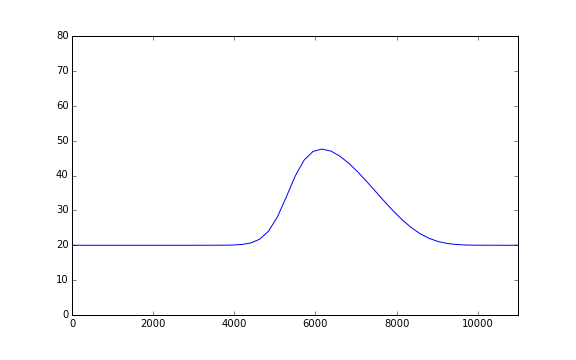
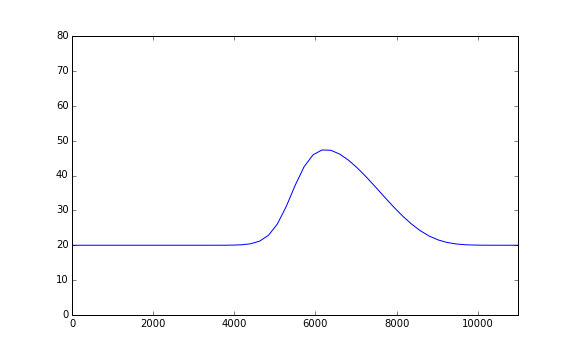
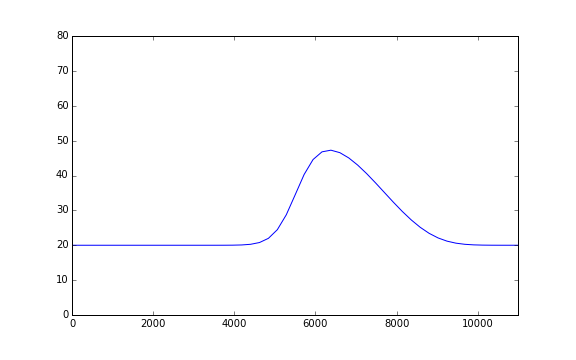
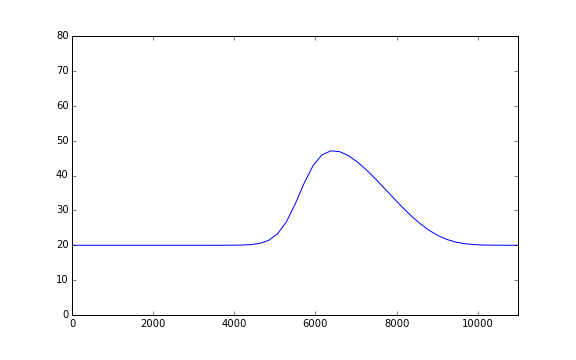
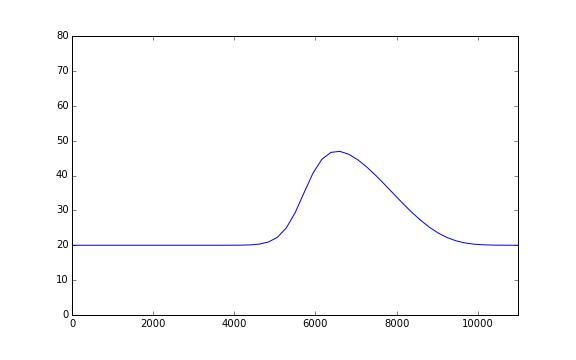
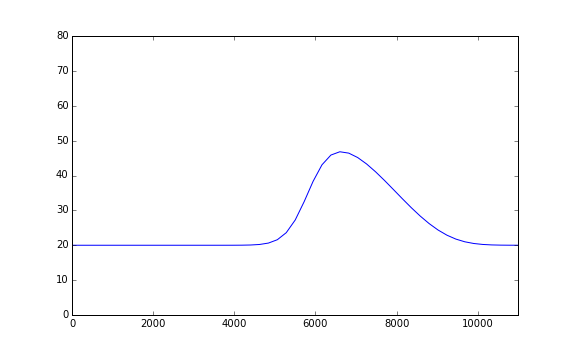
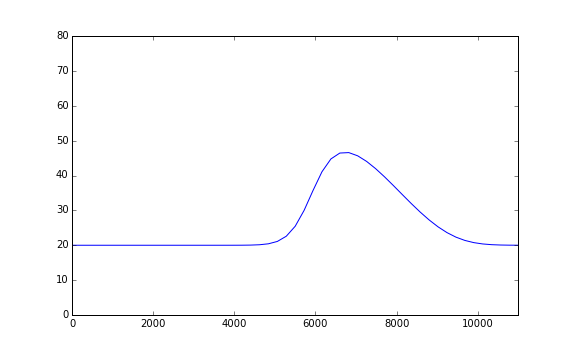
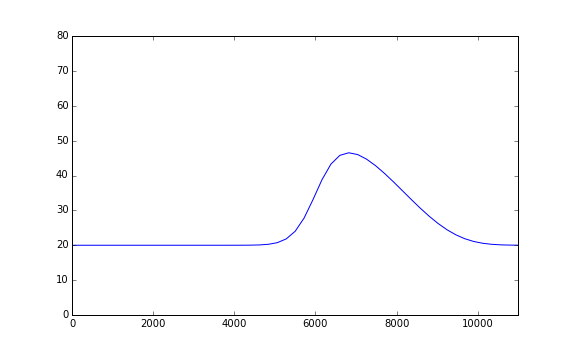
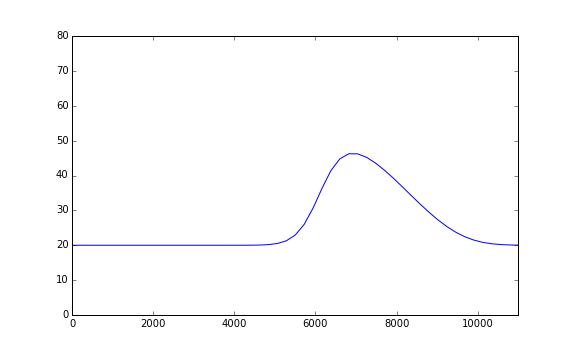
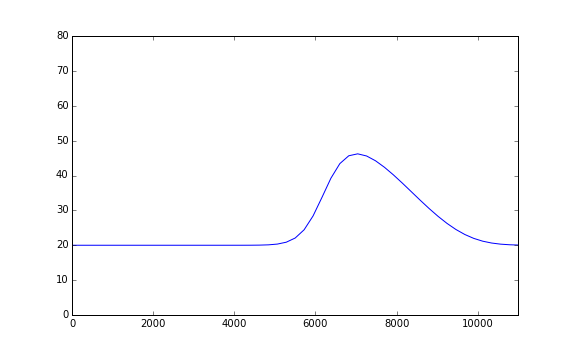
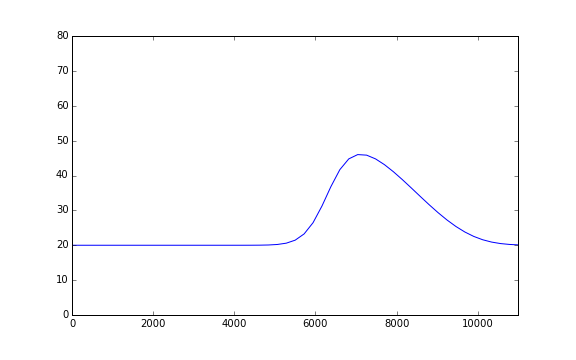
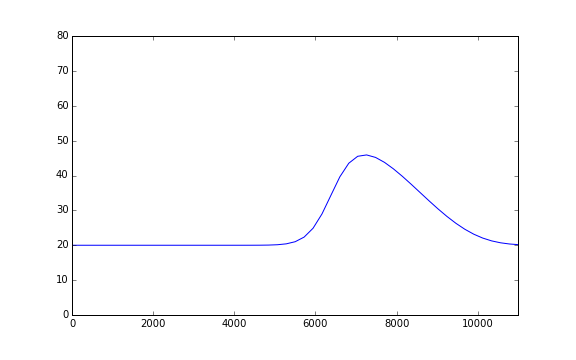
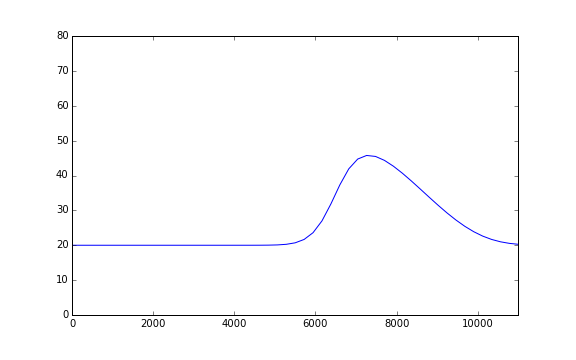
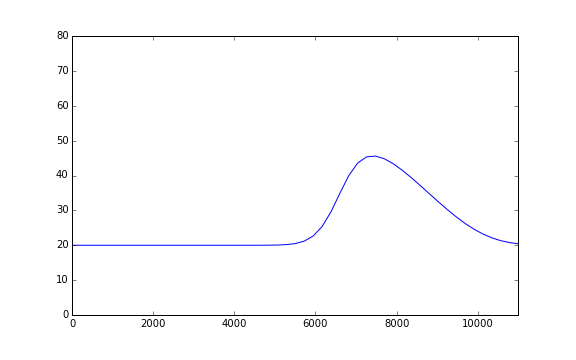
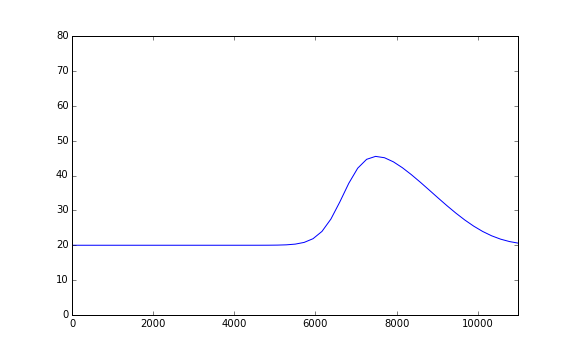
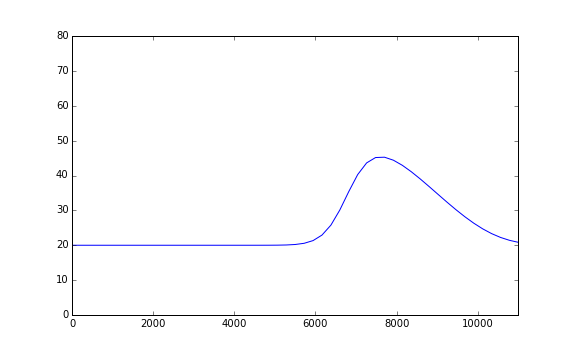
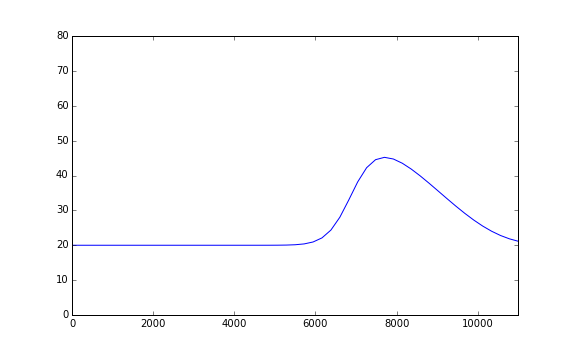

In [35]:
# Creation of the animation
fig = plt.figure(figsize=(8,5))
ax = plt.axes(xlim=(0,11000), ylim=(0,80))
line = ax.plot([], [])[0]

anim.FuncAnimation(fig, lambda i: set_plot(i, line, x, rho),
                        frames=nt, interval=80)

## Conclusion

It was interesting to model a real life problem with numerical analysis. We can see from our amazing animations that, like in a real situation, cars in front of the traffic jam drive at a higher speed than those in the middle of it. Also, the traffic tends to vanish in time if the road is clear.£

##### Source

(1) We used the following lectures https://github.com/numerical-mooc/numerical-mooc available under Creative Commons Attribution license CC-BY 4.0, (c)2014 L.A. Barba, C. Cooper, G.F. Forsyth, A. Krishnan.

---
###### The cell below loads the style of this notebook. 

In [36]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())